In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
from tqdm import tqdm

In [52]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
casp_protein_id = 'T1027'   # 6ya2
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']

da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                       mode='kde_af')
da.load_results_da()

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


5041.1127765100155 3016.77983666189 5502.113555955339
0.0 25.216 24.93199999999999


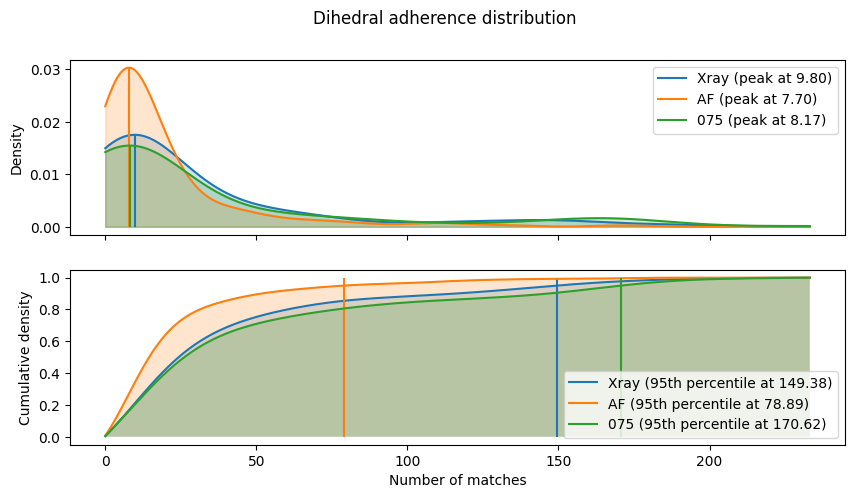

In [150]:
from scipy.stats import gaussian_kde

xray_phi_psi = da.xray_phi_psi.dropna().copy()
af_phi_psi = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == da.alphafold_id].dropna().copy()
results = da.grouped_preds.set_index('protein_id')
xray_phi_psi['rmsd'] = 0
af_phi_psi['rmsd'] = results.loc[da.alphafold_id].RMS_CA

other_id = da.protein_ids[0]
other_phi_psi = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == other_id].dropna().copy()
other_phi_psi['rmsd'] = results.loc[other_id].RMS_CA

print(xray_phi_psi.da.sum(), af_phi_psi.da.sum(), other_phi_psi.da.sum())
print(xray_phi_psi.rmsd.mean(), af_phi_psi.rmsd.mean(), other_phi_psi.rmsd.mean())

df = pd.concat([
    xray_phi_psi, 
    af_phi_psi.drop('da_na', axis=1),
    other_phi_psi.drop('da_na', axis=1)
])

def get_probs(x, da):
    kde = gaussian_kde(da)
    p = kde(x)
    c = np.cumsum(p) / np.sum(p)
    peak = x[np.argmax(p)]
    return p, c, peak

fig, axes = plt.subplots(2, sharex=True, figsize=(10, 5))
x = np.linspace(0, df.da.max(), 1000)

def plot(df, label, color):
    p, c, peak = get_probs(x, df.da)
    axes[0].plot(x, p, color=color, label=f'{label} (peak at {peak:.2f})')
    axes[0].fill_between(x, 0, p, alpha=0.2, color=color)
    axes[0].vlines(peak, 0, p.max(), color=color)
    perc = x[np.argmax(c > 0.95)]
    axes[1].plot(x, c, color=color, label=f'{label} (95th percentile at {perc:.2f})')
    axes[1].vlines(perc, 0, 1, color=color)
    axes[1].fill_between(x, 0, c, alpha=0.2)

colors = sns.color_palette("tab10")
plot(xray_phi_psi, 'Xray', colors[0])
plot(af_phi_psi, 'AF', colors[1])
plot(other_phi_psi, other_id[7:10], colors[2])
axes[0].legend()
axes[0].set_ylabel('Density')
axes[1].legend(loc='lower right')
axes[1].set_xlabel('Number of matches')
axes[1].set_ylabel('Cumulative density')
# axes[0].set_xlim(0, 5000)
# axes[1].set_xlim(0, 5000)
fig.suptitle('Dihedral adherence distribution')
plt.show()

Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found
Slope: -0.4296967237355721, Intercept: 49.388436869951256


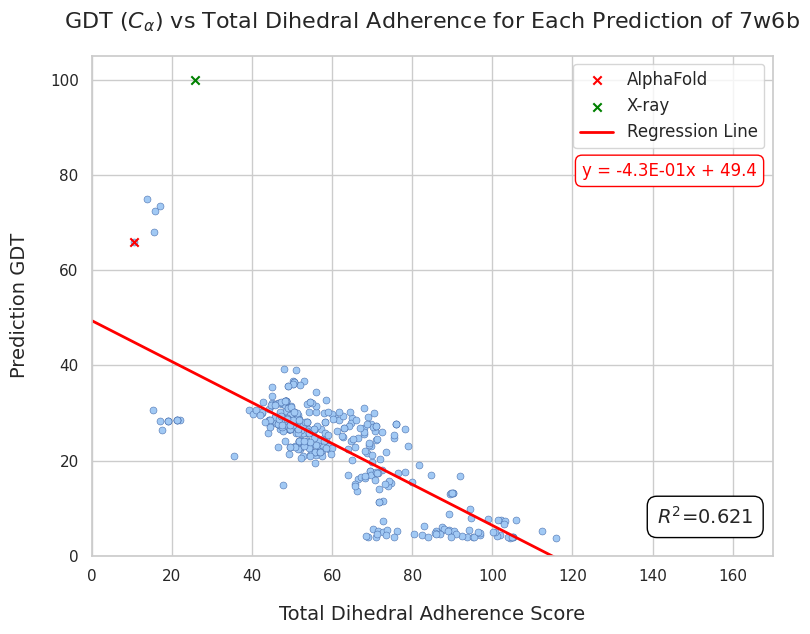

In [148]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']

da = DihedralAdherence(proteins[4], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                       mode='ml', weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda')
da.load_results_da()
da.plot_da_vs_gdt_simple()

In [149]:
gdts = []
scores = []
# thresh = 158.16
# thresholds = np.linspace(0,180, 7)[1:-1] # 51, 102, 153, 204
initial = 32
thresholds = np.array([initial * 2**i for i in range(4)]) # 32, 64, 128, 256
for id in da.protein_ids:
    df = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
    gdt = da.grouped_preds.set_index('protein_id').loc[id].GDT_TS
    # if gdt > 20:
        # continue
    if df.shape[0] == 0:
        continue
    # print(df.shape[0], [(df.da < thresh).sum() for thresh in thresholds], [(df.da < thresh).sum() / df.shape[0] for thresh in thresholds])
    score = np.mean([(df.da < thresh).sum() / df.shape[0] for thresh in thresholds])
    # score = (df.da < thresh).sum() / df.shape[0]
    scores.append(score)
    gdts.append(gdt)
model = stats.linregress(scores, gdts)
print(model.rvalue**2)

0.6343174661099458


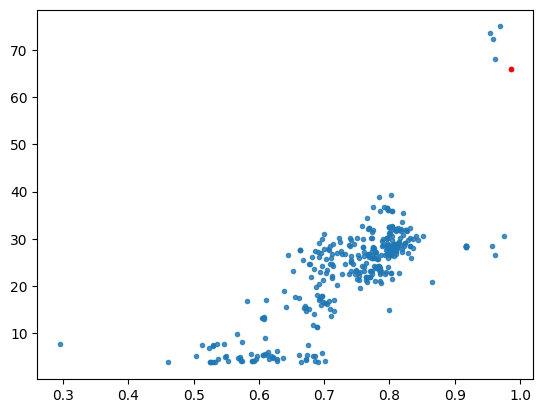

In [150]:
af = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == da.alphafold_id].dropna()
af_score = np.mean([(af.da < thresh).sum() / af.shape[0] for thresh in thresholds])
af_gdt = da.grouped_preds.set_index('protein_id').loc[da.alphafold_id].GDT_TS
plt.scatter(scores, gdts, marker='.', alpha=0.8)
plt.scatter(af_score, af_gdt, color='red', marker='.')
plt.show()

In [ ]:
from scipy import stats
# fit linregr to each and find best threshold
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
proteins = ['T1024', 'T1027', 'T1082', 'T1058', 'T1049', 'T1030', 'T1056']
results = []
for thresh in np.linspace(0, 250, 50):
    for protein in proteins:
        print(f'Protein {protein} threshold {thresh}')
        da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                        mode='kde_af')
        da.load_results_da()
        scores = []
        gdts = []
        pbar = tqdm(da.protein_ids)
        pbar.set_description(f'Protein {protein} Threshold {thresh}')
        for id in pbar:
            preds = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
            if preds.shape[0] == 0:
                continue
            gdt = da.grouped_preds[da.grouped_preds.protein_id == id].GDT_TS.values
            if len(gdt) == 0:
                continue
            gdt = gdt[0]
            score = (preds.da < thresh).sum() / preds.shape[0]
            scores.append(score)
            gdts.append(gdt)
        model = stats.linregress(gdts, scores)
        results.append((protein, thresh, model.slope, model.intercept, model.rvalue**2, model.pvalue))

    results_df = pd.DataFrame(results, columns=['protein', 'threshold', 'slope', 'intercept', 'rsquared', 'pvalue'])
    results_df.to_csv('results_threshold.csv', index=False)

results = pd.DataFrame(results, columns=['protein', 'threshold', 'slope', 'intercept', 'rsquared', 'pvalue'])
results.to_csv('results_threshold.csv', index=False)

In [ ]:
results = pd.read_csv('results_threshold.csv')
results['threshold'] = results['threshold'].round(2)
results.groupby('threshold').describe().sort_values(('rsquared', 'mean'), ascending=False)['rsquared'].head(20)

In [ ]:
results[results.threshold == 158.16]

# Combined

In [181]:
20*2**3

160

In [191]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']


proteins = ['T1024', 'T1027', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
results = []
for thresh1 in np.linspace(1, 32, 64).round(2):
    thresholds = np.array([thresh1 * 2**i for i in range(4)])
    scores = []
    gdts = []
    protein_ids = []
    for protein in proteins:
        da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                            mode='ml', weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda')
        da.load_results_da()
        da.filter_nas(0.8)
        pbar = tqdm(da.protein_ids)
        pbar.set_description(f'Protein {protein} Initial Threshold {thresh1}')

        for id in pbar:
            pred = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
            if pred.shape[0] == 0:
                continue
            gdt = da.grouped_preds[da.grouped_preds.protein_id == id].GDT_TS.values
            if len(gdt) == 0:
                continue
            gdt = gdt[0]
            score = np.mean([(pred.da < thresh).sum() / pred.shape[0] for thresh in thresholds])
            scores.append(score)
            gdts.append(gdt)
            protein_ids.append(protein)
            pred_ids.append(id)
        
    model = stats.linregress(gdts, scores)
    results.append((thresh, model.slope, model.intercept, model.rvalue**2, model.pvalue))

results_df = pd.DataFrame(results, columns=['threshold', 'slope', 'intercept', 'rsquared', 'pvalue'])
results_df.to_csv('results_threshold_combined.csv', index=False)

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Initial Threshold 1.0: 100%|██████████| 484/484 [00:03<00:00, 132.69it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Initial Threshold 1.0: 100%|██████████| 486/486 [00:01<00:00, 298.51it/s]


Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


Protein T1091 Initial Threshold 1.0: 100%|██████████| 399/399 [00:05<00:00, 77.65it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 


Protein T1058 Initial Threshold 1.0: 100%|██████████| 479/479 [00:03<00:00, 140.38it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 


Protein T1049 Initial Threshold 1.0: 100%|██████████| 466/466 [00:01<00:00, 410.33it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


Protein T1030 Initial Threshold 1.0: 100%|██████████| 469/469 [00:02<00:00, 204.86it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Initial Threshold 1.0: 100%|██████████| 490/490 [00:01<00:00, 262.78it/s]


Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
No AlphaFold prediction found for 6ya2
No AlphaFold phi-psi data found


Protein T1038 Initial Threshold 1.0: 100%|██████████| 486/486 [00:01<00:00, 258.53it/s]


Initializing T1025 ...
Results already exist
Casp ID: T1025 	PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 
No CASP AlphaFold prediction


Protein T1025 Initial Threshold 1.0: 100%|██████████| 195/195 [00:00<00:00, 463.99it/s]


Initializing T1028 ...
Results already exist
Casp ID: T1028 	PDB: 6vqp
Structure exists: 'pdb/pdb6vqp.ent' 
No CASP AlphaFold prediction


Protein T1028 Initial Threshold 1.0: 100%|██████████| 194/194 [00:00<00:00, 370.67it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Initial Threshold 1.49: 100%|██████████| 484/484 [00:03<00:00, 128.52it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Initial Threshold 1.49: 100%|██████████| 486/486 [00:01<00:00, 290.89it/s]


Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


Protein T1091 Initial Threshold 1.49: 100%|██████████| 399/399 [00:05<00:00, 79.52it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 


Protein T1058 Initial Threshold 1.49: 100%|██████████| 479/479 [00:03<00:00, 136.97it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 


Protein T1049 Initial Threshold 1.49: 100%|██████████| 466/466 [00:01<00:00, 360.13it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


Protein T1030 Initial Threshold 1.49: 100%|██████████| 469/469 [00:02<00:00, 232.11it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Initial Threshold 1.49: 100%|██████████| 490/490 [00:01<00:00, 266.27it/s]


Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
No AlphaFold prediction found for 6ya2
No AlphaFold phi-psi data found


Protein T1038 Initial Threshold 1.49: 100%|██████████| 486/486 [00:01<00:00, 287.73it/s]


Initializing T1025 ...
Results already exist
Casp ID: T1025 	PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 
No CASP AlphaFold prediction


Protein T1025 Initial Threshold 1.49: 100%|██████████| 195/195 [00:00<00:00, 430.99it/s]


Initializing T1028 ...
Results already exist
Casp ID: T1028 	PDB: 6vqp
Structure exists: 'pdb/pdb6vqp.ent' 
No CASP AlphaFold prediction


Protein T1028 Initial Threshold 1.49: 100%|██████████| 194/194 [00:00<00:00, 371.24it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Initial Threshold 1.98: 100%|██████████| 484/484 [00:03<00:00, 122.21it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Initial Threshold 1.98: 100%|██████████| 486/486 [00:01<00:00, 309.90it/s]


Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


Protein T1091 Initial Threshold 1.98: 100%|██████████| 399/399 [00:05<00:00, 79.56it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 


Protein T1058 Initial Threshold 1.98: 100%|██████████| 479/479 [00:03<00:00, 138.59it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 


Protein T1049 Initial Threshold 1.98: 100%|██████████| 466/466 [00:01<00:00, 408.64it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


Protein T1030 Initial Threshold 1.98: 100%|██████████| 469/469 [00:02<00:00, 209.09it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Initial Threshold 1.98: 100%|██████████| 490/490 [00:01<00:00, 276.69it/s]


Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
No AlphaFold prediction found for 6ya2
No AlphaFold phi-psi data found


Protein T1038 Initial Threshold 1.98: 100%|██████████| 486/486 [00:01<00:00, 257.49it/s]


Initializing T1025 ...
Results already exist
Casp ID: T1025 	PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 
No CASP AlphaFold prediction


Protein T1025 Initial Threshold 1.98: 100%|██████████| 195/195 [00:00<00:00, 399.20it/s]


Initializing T1028 ...
Results already exist
Casp ID: T1028 	PDB: 6vqp
Structure exists: 'pdb/pdb6vqp.ent' 
No CASP AlphaFold prediction


Protein T1028 Initial Threshold 1.98: 100%|██████████| 194/194 [00:00<00:00, 368.57it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Initial Threshold 2.48: 100%|██████████| 484/484 [00:03<00:00, 132.81it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Initial Threshold 2.48: 100%|██████████| 486/486 [00:01<00:00, 303.82it/s]


Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


Protein T1091 Initial Threshold 2.48: 100%|██████████| 399/399 [00:04<00:00, 92.33it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 


Protein T1058 Initial Threshold 2.48: 100%|██████████| 479/479 [00:03<00:00, 141.92it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 


Protein T1049 Initial Threshold 2.48: 100%|██████████| 466/466 [00:01<00:00, 348.27it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


Protein T1030 Initial Threshold 2.48: 100%|██████████| 469/469 [00:01<00:00, 236.83it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Initial Threshold 2.48: 100%|██████████| 490/490 [00:01<00:00, 265.33it/s]


Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
No AlphaFold prediction found for 6ya2
No AlphaFold phi-psi data found


Protein T1038 Initial Threshold 2.48: 100%|██████████| 486/486 [00:01<00:00, 257.88it/s]


Initializing T1025 ...
Results already exist
Casp ID: T1025 	PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 
No CASP AlphaFold prediction


Protein T1025 Initial Threshold 2.48: 100%|██████████| 195/195 [00:00<00:00, 410.99it/s]


Initializing T1028 ...
Results already exist
Casp ID: T1028 	PDB: 6vqp
Structure exists: 'pdb/pdb6vqp.ent' 
No CASP AlphaFold prediction


Protein T1028 Initial Threshold 2.48: 100%|██████████| 194/194 [00:00<00:00, 434.51it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Initial Threshold 2.97: 100%|██████████| 484/484 [00:03<00:00, 133.81it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Initial Threshold 2.97: 100%|██████████| 486/486 [00:01<00:00, 306.42it/s]


Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


Protein T1091 Initial Threshold 2.97: 100%|██████████| 399/399 [00:04<00:00, 93.55it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 


Protein T1058 Initial Threshold 2.97: 100%|██████████| 479/479 [00:03<00:00, 143.24it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 


Protein T1049 Initial Threshold 2.97: 100%|██████████| 466/466 [00:01<00:00, 357.45it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


Protein T1030 Initial Threshold 2.97: 100%|██████████| 469/469 [00:02<00:00, 197.66it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Initial Threshold 2.97: 100%|██████████| 490/490 [00:01<00:00, 312.94it/s]


Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
No AlphaFold prediction found for 6ya2
No AlphaFold phi-psi data found


Protein T1038 Initial Threshold 2.97: 100%|██████████| 486/486 [00:01<00:00, 254.91it/s]


Initializing T1025 ...
Results already exist
Casp ID: T1025 	PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 
No CASP AlphaFold prediction


Protein T1025 Initial Threshold 2.97: 100%|██████████| 195/195 [00:00<00:00, 411.54it/s]


Initializing T1028 ...
Results already exist
Casp ID: T1028 	PDB: 6vqp
Structure exists: 'pdb/pdb6vqp.ent' 
No CASP AlphaFold prediction


Protein T1028 Initial Threshold 2.97: 100%|██████████| 194/194 [00:00<00:00, 363.68it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Initial Threshold 3.46: 100%|██████████| 484/484 [00:03<00:00, 133.32it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Initial Threshold 3.46: 100%|██████████| 486/486 [00:01<00:00, 363.15it/s]


Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


Protein T1091 Initial Threshold 3.46: 100%|██████████| 399/399 [00:05<00:00, 78.69it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 


Protein T1058 Initial Threshold 3.46: 100%|██████████| 479/479 [00:03<00:00, 137.82it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 


Protein T1049 Initial Threshold 3.46: 100%|██████████| 466/466 [00:01<00:00, 351.19it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


Protein T1030 Initial Threshold 3.46: 100%|██████████| 469/469 [00:02<00:00, 227.79it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Initial Threshold 3.46: 100%|██████████| 490/490 [00:01<00:00, 269.82it/s]


Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
No AlphaFold prediction found for 6ya2
No AlphaFold phi-psi data found


Protein T1038 Initial Threshold 3.46: 100%|██████████| 486/486 [00:01<00:00, 257.71it/s]


Initializing T1025 ...
Results already exist
Casp ID: T1025 	PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 
No CASP AlphaFold prediction


Protein T1025 Initial Threshold 3.46: 100%|██████████| 195/195 [00:00<00:00, 449.56it/s]


Initializing T1028 ...
Results already exist
Casp ID: T1028 	PDB: 6vqp
Structure exists: 'pdb/pdb6vqp.ent' 
No CASP AlphaFold prediction


Protein T1028 Initial Threshold 3.46: 100%|██████████| 194/194 [00:00<00:00, 360.52it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Initial Threshold 3.95: 100%|██████████| 484/484 [00:03<00:00, 128.22it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Initial Threshold 3.95: 100%|██████████| 486/486 [00:01<00:00, 299.12it/s]


Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


Protein T1091 Initial Threshold 3.95: 100%|██████████| 399/399 [00:05<00:00, 78.24it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 


Protein T1058 Initial Threshold 3.95: 100%|██████████| 479/479 [00:03<00:00, 141.04it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 


Protein T1049 Initial Threshold 3.95: 100%|██████████| 466/466 [00:01<00:00, 352.78it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


Protein T1030 Initial Threshold 3.95: 100%|██████████| 469/469 [00:02<00:00, 195.43it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Initial Threshold 3.95: 100%|██████████| 490/490 [00:01<00:00, 263.61it/s]


Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
No AlphaFold prediction found for 6ya2
No AlphaFold phi-psi data found


Protein T1038 Initial Threshold 3.95: 100%|██████████| 486/486 [00:01<00:00, 258.53it/s]


Initializing T1025 ...
Results already exist
Casp ID: T1025 	PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 
No CASP AlphaFold prediction


Protein T1025 Initial Threshold 3.95: 100%|██████████| 195/195 [00:00<00:00, 414.84it/s]


Initializing T1028 ...
Results already exist
Casp ID: T1028 	PDB: 6vqp
Structure exists: 'pdb/pdb6vqp.ent' 
No CASP AlphaFold prediction


Protein T1028 Initial Threshold 3.95: 100%|██████████| 194/194 [00:00<00:00, 364.45it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Initial Threshold 4.44: 100%|██████████| 484/484 [00:03<00:00, 134.96it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Initial Threshold 4.44: 100%|██████████| 486/486 [00:01<00:00, 300.45it/s]


Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


Protein T1091 Initial Threshold 4.44: 100%|██████████| 399/399 [00:05<00:00, 79.68it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 


Protein T1058 Initial Threshold 4.44: 100%|██████████| 479/479 [00:03<00:00, 139.78it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 


Protein T1049 Initial Threshold 4.44: 100%|██████████| 466/466 [00:01<00:00, 359.97it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


Protein T1030 Initial Threshold 4.44: 100%|██████████| 469/469 [00:02<00:00, 196.05it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Initial Threshold 4.44: 100%|██████████| 490/490 [00:01<00:00, 314.36it/s]


Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
No AlphaFold prediction found for 6ya2
No AlphaFold phi-psi data found


Protein T1038 Initial Threshold 4.44: 100%|██████████| 486/486 [00:01<00:00, 255.07it/s]


Initializing T1025 ...
Results already exist
Casp ID: T1025 	PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 
No CASP AlphaFold prediction


Protein T1025 Initial Threshold 4.44: 100%|██████████| 195/195 [00:00<00:00, 411.53it/s]


Initializing T1028 ...
Results already exist
Casp ID: T1028 	PDB: 6vqp
Structure exists: 'pdb/pdb6vqp.ent' 
No CASP AlphaFold prediction


Protein T1028 Initial Threshold 4.44: 100%|██████████| 194/194 [00:00<00:00, 362.93it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Initial Threshold 4.94: 100%|██████████| 484/484 [00:03<00:00, 133.56it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Initial Threshold 4.94: 100%|██████████| 486/486 [00:01<00:00, 300.82it/s]


Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


Protein T1091 Initial Threshold 4.94: 100%|██████████| 399/399 [00:04<00:00, 81.20it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 


Protein T1058 Initial Threshold 4.94: 100%|██████████| 479/479 [00:03<00:00, 146.21it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 


Protein T1049 Initial Threshold 4.94: 100%|██████████| 466/466 [00:01<00:00, 350.49it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


Protein T1030 Initial Threshold 4.94: 100%|██████████| 469/469 [00:02<00:00, 201.69it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Initial Threshold 4.94: 100%|██████████| 490/490 [00:01<00:00, 263.21it/s]


Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
No AlphaFold prediction found for 6ya2
No AlphaFold phi-psi data found


Protein T1038 Initial Threshold 4.94: 100%|██████████| 486/486 [00:01<00:00, 253.20it/s]


Initializing T1025 ...
Results already exist
Casp ID: T1025 	PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 
No CASP AlphaFold prediction


Protein T1025 Initial Threshold 4.94: 100%|██████████| 195/195 [00:00<00:00, 409.18it/s]


Initializing T1028 ...
Results already exist
Casp ID: T1028 	PDB: 6vqp
Structure exists: 'pdb/pdb6vqp.ent' 
No CASP AlphaFold prediction


Protein T1028 Initial Threshold 4.94: 100%|██████████| 194/194 [00:00<00:00, 363.36it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Initial Threshold 5.43: 100%|██████████| 484/484 [00:03<00:00, 132.07it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Initial Threshold 5.43: 100%|██████████| 486/486 [00:01<00:00, 303.83it/s]


Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


Protein T1091 Initial Threshold 5.43: 100%|██████████| 399/399 [00:05<00:00, 74.72it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 


Protein T1058 Initial Threshold 5.43: 100%|██████████| 479/479 [00:03<00:00, 140.45it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 


Protein T1049 Initial Threshold 5.43: 100%|██████████| 466/466 [00:01<00:00, 356.15it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


Protein T1030 Initial Threshold 5.43: 100%|██████████| 469/469 [00:02<00:00, 198.34it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Initial Threshold 5.43: 100%|██████████| 490/490 [00:01<00:00, 265.40it/s]


Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
No AlphaFold prediction found for 6ya2
No AlphaFold phi-psi data found


Protein T1038 Initial Threshold 5.43: 100%|██████████| 486/486 [00:01<00:00, 295.84it/s]


Initializing T1025 ...
Results already exist
Casp ID: T1025 	PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 
No CASP AlphaFold prediction


Protein T1025 Initial Threshold 5.43: 100%|██████████| 195/195 [00:00<00:00, 410.21it/s]


Initializing T1028 ...
Results already exist
Casp ID: T1028 	PDB: 6vqp
Structure exists: 'pdb/pdb6vqp.ent' 
No CASP AlphaFold prediction


Protein T1028 Initial Threshold 5.43: 100%|██████████| 194/194 [00:00<00:00, 358.64it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Initial Threshold 5.92: 100%|██████████| 484/484 [00:03<00:00, 132.93it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Initial Threshold 5.92: 100%|██████████| 486/486 [00:01<00:00, 297.47it/s]


Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


Protein T1091 Initial Threshold 5.92: 100%|██████████| 399/399 [00:05<00:00, 78.42it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 


Protein T1058 Initial Threshold 5.92: 100%|██████████| 479/479 [00:03<00:00, 141.04it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 


Protein T1049 Initial Threshold 5.92: 100%|██████████| 466/466 [00:01<00:00, 353.37it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


Protein T1030 Initial Threshold 5.92: 100%|██████████| 469/469 [00:02<00:00, 195.24it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Initial Threshold 5.92: 100%|██████████| 490/490 [00:01<00:00, 273.00it/s]


Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
No AlphaFold prediction found for 6ya2
No AlphaFold phi-psi data found


Protein T1038 Initial Threshold 5.92: 100%|██████████| 486/486 [00:01<00:00, 253.15it/s]


Initializing T1025 ...
Results already exist
Casp ID: T1025 	PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 
No CASP AlphaFold prediction


Protein T1025 Initial Threshold 5.92: 100%|██████████| 195/195 [00:00<00:00, 411.13it/s]


Initializing T1028 ...
Results already exist
Casp ID: T1028 	PDB: 6vqp
Structure exists: 'pdb/pdb6vqp.ent' 
No CASP AlphaFold prediction


Protein T1028 Initial Threshold 5.92: 100%|██████████| 194/194 [00:00<00:00, 361.40it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Initial Threshold 6.41: 100%|██████████| 484/484 [00:03<00:00, 154.50it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Initial Threshold 6.41: 100%|██████████| 486/486 [00:01<00:00, 307.86it/s]


Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


Protein T1091 Initial Threshold 6.41: 100%|██████████| 399/399 [00:05<00:00, 76.56it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 


Protein T1058 Initial Threshold 6.41: 100%|██████████| 479/479 [00:03<00:00, 139.46it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 


Protein T1049 Initial Threshold 6.41: 100%|██████████| 466/466 [00:01<00:00, 351.22it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


Protein T1030 Initial Threshold 6.41: 100%|██████████| 469/469 [00:01<00:00, 236.83it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Initial Threshold 6.41: 100%|██████████| 490/490 [00:01<00:00, 259.24it/s]


Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
No AlphaFold prediction found for 6ya2
No AlphaFold phi-psi data found


Protein T1038 Initial Threshold 6.41: 100%|██████████| 486/486 [00:01<00:00, 246.41it/s]


Initializing T1025 ...
Results already exist
Casp ID: T1025 	PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 


In [8]:
df = pd.read_csv('results_threshold_combined.csv')
df.sort_values('rsquared', ascending=False).head(20)

,threshold,slope,intercept,rsquared,pvalue
73,184.34,-0.000667,0.977215,0.085912,5.094081e-88
74,186.87,-0.000557,0.980972,0.078422,3.402542e-80
72,181.82,-0.000754,0.971889,0.077762,1.650564e-79
67,169.19,-0.001404,0.927888,0.075913,1.376327e-77
66,166.67,-0.001504,0.919953,0.075579,3.053109e-77
68,171.72,-0.001270,0.936128,0.074194,8.332829e-76
65,164.14,-0.001594,0.912525,0.073358,6.113630e-75
64,161.62,-0.001676,0.905678,0.073056,1.256566e-74
58,146.46,-0.002119,0.871008,0.072980,1.504118e-74
57,143.94,-0.002169,0.865832,0.072875,1.931460e-74


In [170]:
np.array([16* 2**i for i in range(4)])

array([ 16,  32,  64, 128])

In [173]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
# proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
proteins = ['T1024', 'T1027', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']

initial = 16
thresholds = np.array([initial * 2**i for i in range(4)])
scores = []
gdts = []
protein_ids = []
pred_ids = []
for protein in proteins:
    da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                        mode='ml', weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda')
    da.load_results_da()
    da.filter_nas(0.8)
    pbar = tqdm(da.protein_ids)
    pbar.set_description(f'Protein {protein}')
    for id in pbar:
        pred = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
        if pred.shape[0] == 0:
            continue
        gdt = da.grouped_preds[da.grouped_preds.protein_id == id].GDT_TS.values
        if len(gdt) == 0:
            continue
        gdt = gdt[0]
        score = np.mean([(pred.da < thresh).sum() / pred.shape[0] for thresh in thresholds])
        scores.append(score)
        gdts.append(gdt)
        protein_ids.append(protein)
        pred_ids.append(id)
das = pd.DataFrame({'protein': protein_ids, 'gdt': gdts, 'score': scores, 'pred_id': pred_ids})

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024: 100%|██████████| 484/484 [00:03<00:00, 134.23it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027: 100%|██████████| 486/486 [00:01<00:00, 301.24it/s]


Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


Protein T1091: 100%|██████████| 399/399 [00:05<00:00, 77.82it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 


Protein T1058: 100%|██████████| 479/479 [00:03<00:00, 142.59it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 


Protein T1049: 100%|██████████| 466/466 [00:01<00:00, 349.79it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


Protein T1030: 100%|██████████| 469/469 [00:02<00:00, 231.10it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056: 100%|██████████| 490/490 [00:01<00:00, 289.28it/s]


Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
No AlphaFold prediction found for 6ya2
No AlphaFold phi-psi data found


Protein T1038: 100%|██████████| 486/486 [00:01<00:00, 288.86it/s]


Initializing T1025 ...
Results already exist
Casp ID: T1025 	PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 
No CASP AlphaFold prediction


Protein T1025: 100%|██████████| 195/195 [00:00<00:00, 422.51it/s]


Initializing T1028 ...
Results already exist
Casp ID: T1028 	PDB: 6vqp
Structure exists: 'pdb/pdb6vqp.ent' 
No CASP AlphaFold prediction


Protein T1028: 100%|██████████| 194/194 [00:00<00:00, 362.25it/s]


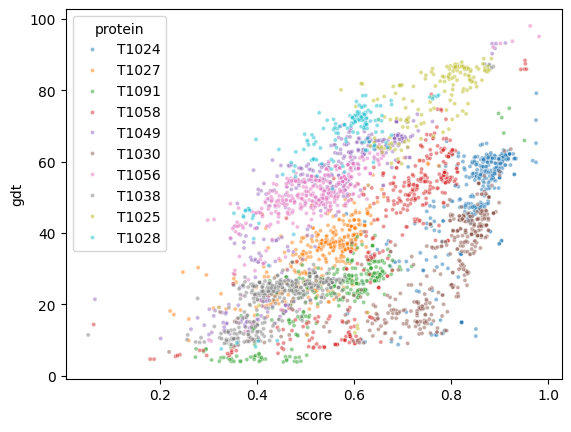

0.27845649488639385

In [175]:
from scipy.stats import linregress
sns.scatterplot(data=das, x='score', y='gdt', hue='protein', marker='.', alpha=0.5)
plt.show()
model = linregress(das.gdt, das.score)
model.rvalue**2